<a href="https://colab.research.google.com/github/apoorvrocks/Machine-Learning-Assignment-1/blob/main/Ass2_Q6_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import np_utils
import pickle

### LAYERS

In [2]:
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    def forward(self, input):
        pass

    def backward(self, output_gradient, learning_rate):
        pass

In [3]:
from scipy import signal

class Convolutional(Layer):
    def __init__(self, input_shape, kernel_size, kernel_depth):
        input_depth, input_height, input_width = input_shape
        self.depth = input_depth
        self.input_shape = input_shape
        self.kernel_depth = kernel_depth
        self.output_shape = (input_depth, input_height - kernel_size + 1, input_width - kernel_size + 1)
        self.kernels_shape = (input_depth, kernel_depth, kernel_size, kernel_size)
        self.kernels = np.random.randn(*self.kernels_shape)
        self.biases = np.random.randn(*self.output_shape)

    def forward(self, input):
        self.input = input
        self.output = np.copy(self.biases)
        for i in range(self.depth):
            for j in range(self.kernel_depth):
                self.output[i] += signal.correlate2d(self.input[j], self.kernels[i, j], "valid")
        return self.output

    def backward(self, output_gradient, learning_rate):
        kernels_gradient = np.zeros(self.kernels_shape)
        input_gradient = np.zeros(self.input_shape)
        for i in range(self.depth):
            for j in range(self.kernel_depth):
                kernels_gradient[i, j] = signal.correlate2d(self.input[j], output_gradient[i], "valid")
                input_gradient[j] += signal.convolve2d(output_gradient[i], self.kernels[i, j], "full")

        self.kernels -= learning_rate * kernels_gradient
        self.biases -= learning_rate * output_gradient
        return input_gradient

In [4]:
class Dense(Layer):
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(output_size, input_size)
        self.bias = np.random.randn(output_size, 1)

    def forward(self, input):
        self.input = input
        return np.dot(self.weights, self.input) + self.bias

    def backward(self, output_gradient, learning_rate):
        weights_gradient = np.dot(output_gradient, self.input.T)
        input_gradient = np.dot(self.weights.T, output_gradient)
        self.weights -= learning_rate * weights_gradient
        self.bias -= learning_rate * output_gradient
        return input_gradient

In [5]:
class Reshape(Layer):
    def __init__(self, input_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape

    def forward(self, input):
        return np.reshape(input, self.output_shape)

    def backward(self, output_gradient, learning_rate):
        return np.reshape(output_gradient, self.input_shape)

In [6]:
class Softmax(Layer):
    def forward(self, input):
        tmp = np.exp(input)
        self.output = tmp / np.sum(tmp)
        return self.output
    
    def backward(self, output_gradient, learning_rate):
        n = np.size(self.output)
        return np.dot((np.identity(n) - self.output.T) * self.output, output_gradient)

In [7]:
class Maxpool(Layer):
    def __init__(self, input_shape, kernel_size):
        input_depth, input_height, input_width = input_shape
        self.depth = input_depth
        self.input_shape = input_shape
        self.output_shape = (depth, input_height - kernel_size + 1, input_width - kernel_size + 1)
        self.kernel_size = kernel_size

    def forward(self, input):
        output_conv = np.zeros(self.output_shape)
        self.maxargs = np.zeros((self.output_shape[0], self.output_shape[1], self.output_shape[2], 2))
        for d in range(self.depth):
            for i in range(self.input_shape[1] - self.kernel_size + 1):
                for j in range(self.input_shape[1] - self.kernel_size + 1):
                    mat = input[d, i:self.kernel_size + i, j:self.kernel_size+j]
                    indices = np.where(mat == mat.max())
                    try:
                        output_conv[d, i, j] = mat[indices[0][0], indices[1][0]]
                        self.maxargs[d, i, j] = [indices[0][0]+i, indices[1][0]+j]
                    except IndexError:
                        print(indices)
                        print(mat)
                        raise Exception("Nan in maxpool")
        return output_conv

    def backward(self, output_gradient, learning_rate):
        back_layer = np.zeros(self.input_shape)
        for d in range(self.depth):
            for i in range(self.input_shape[1] - self.kernel_size + 1):
                for j in range(self.input_shape[1] - self.kernel_size + 1):
                    ind = self.maxargs[d, i, j]
                    back_layer[d, int(ind[0]), int(ind[1])] = output_gradient[d, i, j]
        return back_layer

In [8]:
class Avgpool(Layer):
    def __init__(self, input_shape, kernel_size):
        input_depth, input_height, input_width = input_shape
        self.depth = input_depth
        self.input_shape = input_shape
        self.output_shape = (depth, input_height - kernel_size + 1, input_width - kernel_size + 1)
        self.kernel_size = kernel_size

    def forward(self, input):
        output_conv = np.zeros(self.output_shape)
        for d in range(self.depth):
            for i in range(self.input_shape[1] - self.kernel_size + 1):
                for j in range(self.input_shape[1] - self.kernel_size + 1):
                    output_conv[d, i, j] = np.mean(input[d, i:self.kernel_size + i, j:self.kernel_size+j])
        return output_conv

    def backward(self, output_gradient, learning_rate):
        count_layer = np.zeros(self.input_shape)
        back_layer = np.zeros(self.input_shape)
        for d in range(self.depth):
            for i in range(self.input_shape[1] - self.kernel_size + 1):
                for j in range(self.input_shape[1] - self.kernel_size + 1):
                    count_layer[d, i:self.kernel_size + i, j:self.kernel_size+j] += 1
                    back_layer[d, i:self.kernel_size + i, j:self.kernel_size+j] += output_gradient[d, i, j]
        return back_layer / count_layer

### ACTIVATION LAYER

In [9]:
class Activation(Layer):
    def __init__(self, activation, activation_prime, *args):
        self.params = args
        self.activation = activation
        self.activation_prime = activation_prime

    def forward(self, input):
        self.input = input
        return self.activation(self.input, self.params)

    def backward(self, output_gradient, learning_rate):
        return np.multiply(output_gradient, self.activation_prime(self.input, self.params))

In [10]:
def sigmoid(x, args):
    return 1 / (1 + np.exp(-x))

def sigmoid_prime( x, args):
    s = sigmoid(x, args)
    return s * (1 - s)

def tanh(x, args):
    return np.tanh(x)

def tanh_prime(x, args):
    return 1 - np.tanh(x) ** 2

def relu(x, args):
    return np.maximum(x, 0)

def relu_prime(x, args):
    return (x>0).astype(x.dtype)

def lkrelu(x, args):
    a = np.maximum(x, 0)
    b = np.minimum(x * args[0], 0)
    return a + b

def lkrelu_prime(x, args):
    a = (x>0).astype(x.dtype)
    b = (x<0).astype(x.dtype) * args[0]
    return a + b

In [11]:
class Tanh(Activation):
    def __init__(self):
        super().__init__(tanh, tanh_prime)


class Sigmoid(Activation):
    def __init__(self):
        super().__init__(sigmoid, sigmoid_prime)


class Relu(Activation):
    def __init__(self):
        super().__init__(relu, relu_prime)


class LkRelu(Activation):
    def __init__(self, lk_const):
        super().__init__(lkrelu, lkrelu_prime, lk_const)

## **Loss** functions

In [12]:
def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))

def mse_prime(y_true, y_pred):
    return 2 * (y_pred - y_true) / np.size(y_true)

def binary_cross_entropy(y_true, y_pred):
    ans = np.mean(-y_true * np.log(1e-10 + y_pred) - (1 - y_true) * np.log(1e-10 + 1 - y_pred))
    if np.isnan(np.sum(ans)):
        print('found nan')
        print()
    return ans

def binary_cross_entropy_prime(y_true, y_pred):
    return ((1 - y_true) / (1e-10 + 1 - y_pred) - y_true / (1e-10 + y_pred)) / np.size(y_true)


### Train and Predict functions

In [13]:
def predict(network, input):
    output = input
    for layer in network:
        output = layer.forward(output)
    return output

def train(network, loss, loss_prime, x_train, y_train, epochs = 1000, learning_rate = 0.01, verbose = True):
    errors = []
    for e in range(epochs):
        error = 0
        for x, y in zip(x_train, y_train):
            # forward
            output = predict(network, x)
            
            # error
            error += loss(y, output)

            # backward
            grad = loss_prime(y, output)
            for layer in reversed(network):
                grad = layer.backward(grad, learning_rate)

        error /= len(x_train)
        errors.append(error)
        if verbose:
            print(f"{e + 1}/{epochs}, error={error}")
    print(loss, learning_rate, errors)

### Load PneumoniaMNIST dataset

In [14]:
data_path = '/content/drive/MyDrive/IISc/PRNN/pneumoniamnist.npz'

data = np.load(data_path)
print('DATA FILES:', data.files)

x_train = data['train_images'].reshape(data['train_images'].shape[0],-1)
x_test = data['test_images'].reshape(data['test_images'].shape[0],-1)
x_val = data['val_images'].reshape(data['val_images'].shape[0],-1)
y_train = data['train_labels']
y_test = data['test_labels']
y_val = data['val_labels']

DATA FILES: ['train_images', 'val_images', 'test_images', 'train_labels', 'val_labels', 'test_labels']


### Display data

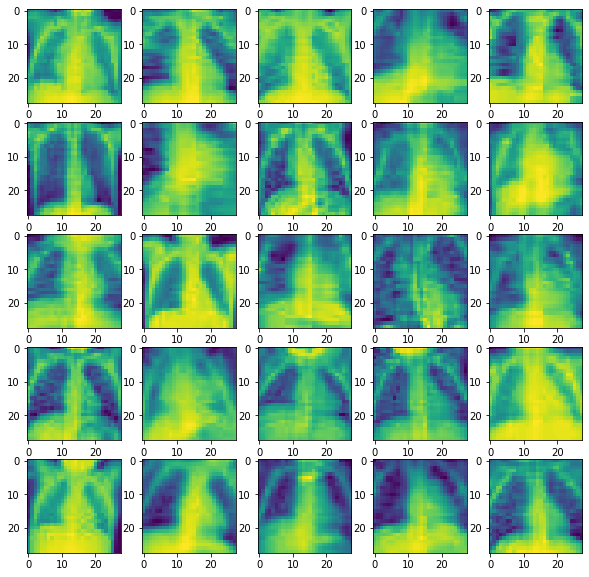

In [15]:
plt.figure(figsize=(10,10)) # specifying the overall grid size

for i in range(25):
    plt.subplot(5,5,i+1)    # the number of images in the grid is 5*5 (25)
    plt.imshow(x_train[i].reshape(28,28))

plt.show()

### data preprocessing

In [16]:
def preprocess_data(x, y, limit=None):
    x = x[:limit]
    y = y[:limit]
    x = x.reshape(len(x), 1, 28, 28)
    x = x.astype("float32") / 255
    y = np_utils.to_categorical(y)
    y = y.reshape(len(y), 2, 1)
    return x, y

x_train, y_train = preprocess_data(x_train, y_train)
x_test, y_test = preprocess_data(x_test, y_test)
x_val, y_val = preprocess_data(x_val, y_val)

### EXPERIMENTS

In [21]:
depth = 1
img_size = 28
kernel_size = 3
l1_size = img_size - kernel_size + 1
l2_size = l1_size - kernel_size + 1
l3_size = l2_size - kernel_size + 1
l4_size = l3_size - kernel_size + 1
no_class = 2

In [22]:
for lr in [0.03]:

    print('learning rate: ', lr)
    network = [
        Convolutional((depth, img_size, img_size), kernel_size, depth),
        LkRelu(0.1),
        # Sigmoid(),
        # Tanh(),
        Maxpool((depth, l1_size, l1_size), kernel_size),

        Convolutional((depth, l2_size, l2_size), kernel_size, depth),
        LkRelu(0.1),
        # Sigmoid(),
        # Tanh(),
        Maxpool((depth, l3_size, l3_size), kernel_size),
        
        Reshape((depth, l4_size, l4_size), (depth * l4_size * l4_size, 1)),
        Dense(depth * l4_size * l4_size, no_class),
        Sigmoid(),
    ]
    train(network, mse, mse_prime, x_train, y_train, epochs=20, learning_rate=lr)
    # train(network,binary_cross_entropy, binary_cross_entropy_prime, x_train, y_train, epochs=20, learning_rate=lr)


    filename = '/content/drive/MyDrive/IISc/PRNN/pneumonia_mse_tanh_max' + str(lr) + '.sav'
    pickle.dump(network, open(filename, 'wb'))



In [23]:
def plot_error(lkrelu, tan, sig, title_name):
    x = range(1, 21)
    
    plt.plot(x, lkrelu, label = "lkrelu")
    plt.plot(x, tan, label = "tan")
    plt.plot(x, sig, label = "sig")

    plt.xlabel('iteration')

    plt.ylabel('training error')
    plt.xticks(np.arange(0, 21, 5.0))
    plt.legend()

    plt.title(title_name)

    plt.show()



BCE with AVG POOLING

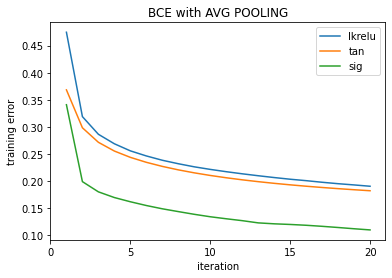

In [24]:
lkrelu = [0.4747818004101769, 0.3188734149330429, 0.2862547971793615, 0.2687112641984476, 0.2556337056875676, 0.2462359868768398, 0.23826004027071682, 0.2318444159016001, 0.2261289951335449, 0.22137456889380588, 0.21711853365362097, 0.21323527059710698, 0.20966434008541143, 0.2063060317474012, 0.20321036288853503, 0.20055798661032362, 0.19759631492736435, 0.19495300840765312, 0.1926703911496911, 0.19023633430532685]
tan = [0.3683030558325162, 0.2982732200032237, 0.27144236957715967, 0.2552685528750089, 0.24361628050946948, 0.2344634895242117, 0.22692096582541477, 0.2205264210560276, 0.21500595827446906, 0.21017861552537964, 0.20591496124588338, 0.20211763610535913, 0.19871112607760114, 0.1956356343409419, 0.19284298034056852, 0.190293672818238, 0.18795477389680532, 0.18579834804007386, 0.18380035691430993, 0.18193989000460514]
sig = [0.34087460467948766, 0.19877373971527, 0.17988636682535558, 0.16936298099237573, 0.161588613207857, 0.15463758690698848, 0.14857579191402145, 0.14340675786465598, 0.1383866547531974, 0.13386582695407506, 0.13015413232879464, 0.12666428765716958, 0.12256218499379581, 0.12082662176167672, 0.11964272693895221, 0.11814497408016796, 0.1162036922972584, 0.11402638736883679, 0.1117015531983278, 0.10955592357861446]


plot_error(lkrelu, tan, sig, 'BCE with AVG POOLING')

MSE with AVG POOLING

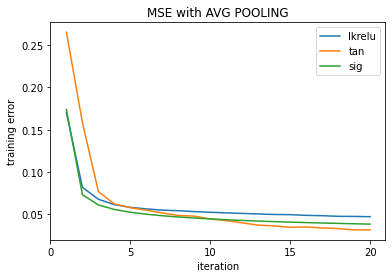

In [25]:
lkrelu = [0.17017044197867887, 0.08205646848036662, 0.06792743661735548, 0.06161717544870341, 0.058400447769723716, 0.056573321219226876, 0.05512222332590442, 0.054421434180479435, 0.05337529035712666, 0.05258421594926167, 0.051864621467961704, 0.05124855315930184, 0.050555957530532165, 0.049976384183125354, 0.049762297574685976, 0.04894182869077607, 0.048548486553479375, 0.04781939799815194, 0.04768321355340353, 0.047381773049915026]
tan = [0.2650424515968506, 0.15851426781542774, 0.07701850234563816, 0.06237823946238557, 0.05794830836638308, 0.05509559344165888, 0.0516944259197295, 0.04879990202107567, 0.04803862438326049, 0.04470772724400073, 0.04270862251067052, 0.04009264215506254, 0.03740388411951699, 0.036476308778479814, 0.03483908229836555, 0.03523939237670782, 0.03400795387873991, 0.03332729697431425, 0.03176441250441877, 0.03176017462152598]
sig = [0.1737430756539569, 0.07337916671685554, 0.06119527843581611, 0.05590455603922837, 0.052610817539409736, 0.05028180224160222, 0.04848369076091403, 0.047015729387201215, 0.04582024598550051, 0.04475803961347205, 0.0437904704086736, 0.04294566522427755, 0.042209900985441105, 0.041556236793768055, 0.040966981533280725, 0.04042779736454176, 0.0399278950984973, 0.03945903414902827, 0.03901485323627947, 0.038590152843753854]

plot_error(lkrelu, tan, sig, 'MSE with AVG POOLING')

BCE with MAX POOLING

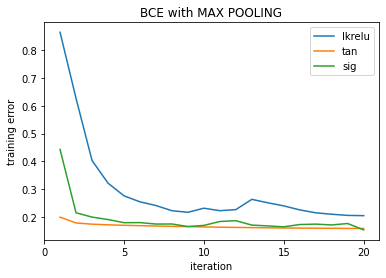

In [26]:
lkrelu = [0.8643659189558077, 0.6264521625238622, 0.4033552557179052, 0.3217069543051573, 0.2761202489900797, 0.25447684258952985, 0.2412132142258065, 0.22251092211132853, 0.2168626657312749, 0.23154486753468095, 0.22265798462879266, 0.22650808125990474, 0.2633853428299903, 0.2510841900598232, 0.2398850459867339, 0.2254675294136962, 0.21499043794039518, 0.2098590867970654, 0.20570094164466887, 0.20470348830376453]
tan = [0.1994012189058395, 0.1785261527212248, 0.17414827914623524, 0.17181069437222574, 0.1700729256973187, 0.16870048771793816, 0.16743404358039982, 0.1662911826422376, 0.1652676171443507, 0.1641950421673436, 0.16331017084397362, 0.16253420272496935, 0.1617575609225458, 0.16100508317797566, 0.16038097604030838, 0.16005902565991892, 0.15957088564887048, 0.1592742998734676, 0.1589693214450937, 0.15859749553620595]
sig = [0.4428410150333807, 0.21510352969277527, 0.19956915206887288, 0.19081532488208933, 0.17949084143075897, 0.17983214777550013, 0.17455352848112482, 0.17476848614335144, 0.16563537082178367, 0.16971613060618662, 0.18376585201182014, 0.18668434254961186, 0.17086299750530304, 0.1678381780286268, 0.1646209936554684, 0.17286537272191796, 0.1742871588598454, 0.17132392223393658, 0.1765233716497451, 0.15347842884822074]

plot_error(lkrelu, tan, sig, 'BCE with MAX POOLING')

MSE with MAX POOLING

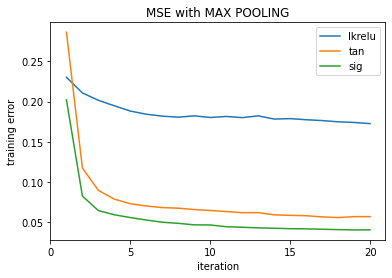

In [27]:
lkrelu = [0.23029101843895117, 0.21078570228950405, 0.20158138927074537, 0.19474419643898278, 0.18815458335022603, 0.18424613008154314, 0.18183468489105736, 0.1805466690493459, 0.18220987631501412, 0.18016481234895465, 0.18145497734506408, 0.17999948145823283, 0.18217622604362668, 0.17820597431432642, 0.1787322959091799, 0.17737297657519085, 0.17632574666487127, 0.17477326923678396, 0.1739809492362529, 0.17253047643159306]
tan = [0.2864161180730491, 0.1171787840456092, 0.08931453860393584, 0.07839107155040978, 0.07260929186475672, 0.06984082124622497, 0.06785055291312259, 0.06712175770875495, 0.06541514286345129, 0.06419149453613708, 0.06294312229022413, 0.06150988861715394, 0.061558530809590666, 0.05879517788368182, 0.0582333192350261, 0.05770720818138053, 0.05623750571393402, 0.0554367887513832, 0.05660221064209325, 0.05657962152550537]
sig = [0.20227631614153863, 0.08218461830269325, 0.06413003909879882, 0.05891429327860504, 0.05541166701816943, 0.052354830267404846, 0.04960174604202379, 0.0482224905679158, 0.04633460010331199, 0.04618303963666931, 0.04400527125481977, 0.04334094099906639, 0.042583515929895656, 0.0421077043654022, 0.04152991134040976, 0.04132417809888411, 0.04089132959152045, 0.04040707544593809, 0.04002359673988417, 0.04015177654415533]

plot_error(lkrelu, tan, sig, 'MSE with MAX POOLING')

Choose best model using validation set

In [17]:
def classification_accuracy(x_data, y_data, model):
    acc = 0
    for x, y in zip(x_data, y_data):
        pred = predict(model, x)
        if np.argmax(pred) == np.argmax(y):
            acc += 1
    acc /= len(x_data)
    return acc

In [18]:
for loss in ['bce', 'mse']:
    for act in ['tanh', 'sigmoid', 'lkrelu']:
        for pool in ['avg', 'max']:
            print('\n\n')
            for lr in [0.01, 0.03, 0.001, 0.003, 1e-5]:
                filename = f'/content/drive/MyDrive/IISc/PRNN/pneumonia_{loss}_{act}_{pool}{lr}.sav'
                try:
                    model = pickle.load(open(filename, 'rb'))
                    print(filename, end = ' ')
            
                    acc = classification_accuracy(x_val, y_val, model)
                    print(f'validation accuracy = {acc}', end = ' ')
                    acc = classification_accuracy(x_test, y_test, model)
                    print(f'test accuracy = {acc}')
                except FileNotFoundError:
                    print(end='')




/content/drive/MyDrive/IISc/PRNN/pneumonia_bce_tanh_avg0.03.sav validation accuracy = 0.9293893129770993 test accuracy = 0.875
/content/drive/MyDrive/IISc/PRNN/pneumonia_bce_tanh_avg0.001.sav validation accuracy = 0.7423664122137404 test accuracy = 0.625
/content/drive/MyDrive/IISc/PRNN/pneumonia_bce_tanh_avg0.003.sav validation accuracy = 0.9026717557251909 test accuracy = 0.780448717948718
/content/drive/MyDrive/IISc/PRNN/pneumonia_bce_tanh_avg1e-05.sav validation accuracy = 0.8778625954198473 test accuracy = 0.7964743589743589



/content/drive/MyDrive/IISc/PRNN/pneumonia_bce_tanh_max0.01.sav validation accuracy = 0.7423664122137404 test accuracy = 0.625
/content/drive/MyDrive/IISc/PRNN/pneumonia_bce_tanh_max0.001.sav validation accuracy = 0.7423664122137404 test accuracy = 0.625



/content/drive/MyDrive/IISc/PRNN/pneumonia_bce_sigmoid_avg0.001.sav validation accuracy = 0.9561068702290076 test accuracy = 0.8685897435897436



/content/drive/MyDrive/IISc/PRNN/pneumonia_bce_sigmoi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


validation accuracy = 0.25763358778625955 test accuracy = 0.375



/content/drive/MyDrive/IISc/PRNN/pneumonia_mse_lkrelu_max0.01.sav validation accuracy = 0.25763358778625955 test accuracy = 0.375
/content/drive/MyDrive/IISc/PRNN/pneumonia_mse_lkrelu_max0.001.sav validation accuracy = 0.7423664122137404 test accuracy = 0.625
/content/drive/MyDrive/IISc/PRNN/pneumonia_mse_lkrelu_max0.003.sav validation accuracy = 0.7423664122137404 test accuracy = 0.625


In [21]:
best_models = ['/content/drive/MyDrive/IISc/PRNN/pneumonia_bce_tanh_avg0.03.sav',
'/content/drive/MyDrive/IISc/PRNN/pneumonia_bce_tanh_max0.01.sav',
'/content/drive/MyDrive/IISc/PRNN/pneumonia_bce_sigmoid_avg0.001.sav',
'/content/drive/MyDrive/IISc/PRNN/pneumonia_bce_sigmoid_max0.001.sav',
'/content/drive/MyDrive/IISc/PRNN/pneumonia_bce_lkrelu_avg0.01.sav',
'/content/drive/MyDrive/IISc/PRNN/pneumonia_bce_lkrelu_max0.003.sav',
'/content/drive/MyDrive/IISc/PRNN/pneumonia_mse_tanh_avg0.001.sav',
'/content/drive/MyDrive/IISc/PRNN/pneumonia_mse_tanh_max0.03.sav',
'/content/drive/MyDrive/IISc/PRNN/pneumonia_mse_sigmoid_avg0.001.sav',
'/content/drive/MyDrive/IISc/PRNN/pneumonia_mse_sigmoid_max0.001.sav',
'/content/drive/MyDrive/IISc/PRNN/pneumonia_mse_lkrelu_avg0.03.sav',
'/content/drive/MyDrive/IISc/PRNN/pneumonia_mse_lkrelu_max0.003.sav']


Get accuracy, f1 score, AOC

In [19]:
def get_metrics(pred,actual):

    n_correct_preds = 0
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    for i in range(len(actual)):
        p = np.argmax(pred[i])
        a = np.argmax(actual[i])
        if a == p:
            if a==1:
                tp += 1
            else:
                tn += 1
        else:
            if a==1:
                fn += 1
            else:
                fp += 1

    accuracy = (tp+tn)/len(pred)
    if tp+fn==0:
        recall= 0 
    else:
        recall = tp/(tp+fn)
    if tp+fp==0:
        precision = 0
    else:   
        precision = tp/(tp+fp)
    if recall==0 and precision==0:
        F1 = 0 
    else:
        F1 = 2*recall*precision/(recall+precision)
    if tn+fp==0:
        specificity = 0
    else:
        specificity = tn/(tn+fp)
    AUC = (recall + specificity)/2

    return accuracy,F1,AUC

In [22]:
for filename in best_models:
    model = pickle.load(open(filename, 'rb'))
    op = []
    for x in x_test:
        op.append(predict(model, x))

    metr = get_metrics(np.array(op), y_test)
    print(f'{filename} accuracy = {metr[0]}, F1 = {metr[1]}, AUC = {metr[2]}')
    



/content/drive/MyDrive/IISc/PRNN/pneumonia_bce_tanh_avg0.03.sav accuracy = 0.875, F1 = 0.9046454767726161, AUC = 0.8504273504273504
/content/drive/MyDrive/IISc/PRNN/pneumonia_bce_tanh_max0.01.sav accuracy = 0.625, F1 = 0.7692307692307693, AUC = 0.5
/content/drive/MyDrive/IISc/PRNN/pneumonia_bce_sigmoid_avg0.001.sav accuracy = 0.8685897435897436, F1 = 0.9035294117647059, AUC = 0.82991452991453
/content/drive/MyDrive/IISc/PRNN/pneumonia_bce_sigmoid_max0.001.sav accuracy = 0.8621794871794872, F1 = 0.8971291866028708, AUC = 0.829059829059829
/content/drive/MyDrive/IISc/PRNN/pneumonia_bce_lkrelu_avg0.01.sav accuracy = 0.7131410256410257, F1 = 0.8085561497326202, AUC = 0.6277777777777778
/content/drive/MyDrive/IISc/PRNN/pneumonia_bce_lkrelu_max0.003.sav accuracy = 0.8493589743589743, F1 = 0.8896713615023474, AUC = 0.8085470085470086
/content/drive/MyDrive/IISc/PRNN/pneumonia_mse_tanh_avg0.001.sav accuracy = 0.8525641025641025, F1 = 0.8922716627634661, AUC = 0.8111111111111111
/content/drive/